In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import os
import bambi
from utils import get_behavior
import arviz as az

bids_folder = '/Users/mrenke/data/ds-dnumr'
target_folder = op.join(bids_folder, 'derivatives', 'cogmodels')

if not op.exists(target_folder):
    os.makedirs(target_folder)

In [2]:
df = get_behavior(subject_list = ['1', '02', '03', 'test1'])
df['x'] = df['log(risky/safe)']
df

choice    n1    n2  prob1  prob2  \
subject session format       trial_nr                                     
1       1       non-symbolic 1            2.0  47.0  28.0   0.55   0.55   
                             2            2.0  33.0  20.0   0.55   0.55   
                             3            1.0  28.0   7.0   0.55   0.55   
                             4            2.0  40.0  20.0   0.55   0.55   
                             5            2.0  11.0   7.0   0.55   0.55   
...                                       ...   ...   ...    ...    ...   
test1   1       symbolic     188          1.0  14.0  19.0   1.00   1.00   
                             189          1.0  28.0  66.0   1.00   1.00   
                             190          1.0   7.0  19.0   1.00   1.00   
                             191          1.0  10.0  20.0   1.00   1.00   
                             192          1.0  28.0  79.0   1.00   1.00   

                                       risky_left  chose_risky  n_risky  \
subject session format       trial_nr                                     
1       1       non-symbolic 1               True        False     47.0   
                             2               True        False     33.0   
                             3               True         True     28.0   
                             4               True        False     40.0   
                             5               True        False     11.0   
...                                           ...          ...      ...   
test1   1       symbolic     188            False        False     19.0   
                             189            False        False     66.0   
                             190            False        False     19.0   
                             191            False        False     20.0   
                             192            False        False     79.0   

                                       n_safe      frac  log(risky/safe)  \
subject session format       trial_nr                                      
1       1       non-symbolic 1           28.0  1.678571         0.517943   
                             2           20.0  1.650000         0.500775   
                             3            7.0  4.000000         1.386294   
                             4           20.0  2.000000         0.693147   
                             5            7.0  1.571429         0.451985   
...                                       ...       ...              ...   
test1   1       symbolic     188         14.0  1.357143         0.305382   
                             189         28.0  2.357143         0.857450   
                             190          7.0  2.714286         0.998529   
                             191         10.0  2.000000         0.693147   
                             192         28.0  2.821429         1.037243   

                                        log(n1)         x  
subject session format       trial_nr                      
1       1       non-symbolic 1         3.850148  0.517943  
                             2         3.496508  0.500775  
                             3         3.332205  1.386294  
                             4         3.688879  0.693147  
                             5         2.397895  0.451985  
...                                         ...       ...  
test1   1       symbolic     188       2.639057  0.305382  
                             189       3.332205  0.857450  
                             190       1.945910  0.998529  
                             191       2.302585  0.693147  
                             192       3.332205  1.037243  

[1526 rows x 13 columns]

In [3]:
model = bambi.Model('chose_risky ~ x + (x|subject)', link='probit', family='bernoulli', data=df.reset_index())

model = bambi.Model('chose_risky ~ x + (x*format|subject)', link='probit', family='bernoulli', data=df.reset_index())


In [ ]:
traces = model.fit(init='adapt_diag', target_accept=0.9, draws=1000, tune=1000)

In [5]:

model_label = 'prelim_first-subs_probit'
model_label = 'prelim_first-subs_diff-format_probit'

az.to_netcdf(traces,
                op.join(target_folder, f'model-{model_label}_trace.netcdf'))

'/Users/mrenke/data/ds-dnumr/derivatives/cogmodels/model-prelim_first-subs_diff-format_probit_trace.netcdf'

In [ ]:
az.plot_trace(traces)

In [7]:
from utils import extract_rnp_precision

model_label = 'prelim_first-subs_probit'

traces = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels/model-{model_label}_trace.netcdf'))

intercept, gamma = extract_rnp_precision(traces, model, df, format = False)

In [4]:
from utils import extract_rnp_precision
model_label = 'prelim_first-subs_diff-format_probit'

traces = az.from_netcdf(op.join(bids_folder, f'derivatives/cogmodels/model-{model_label}_trace.netcdf'))

intercept, gamma = extract_rnp_precision(traces, model, df, format = True)

In [11]:
rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])
rnp.columns = ['rnp']
rnp.reset_index()['format']

/Users/mrenke/mambaforge/envs/behav_fit2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


0         non-symbolic
1         non-symbolic
2         non-symbolic
3         non-symbolic
4         non-symbolic
              ...     
191995        symbolic
191996        symbolic
191997        symbolic
191998        symbolic
191999        symbolic
Name: format, Length: 192000, dtype: object

/Users/mrenke/mambaforge/envs/behav_fit2/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


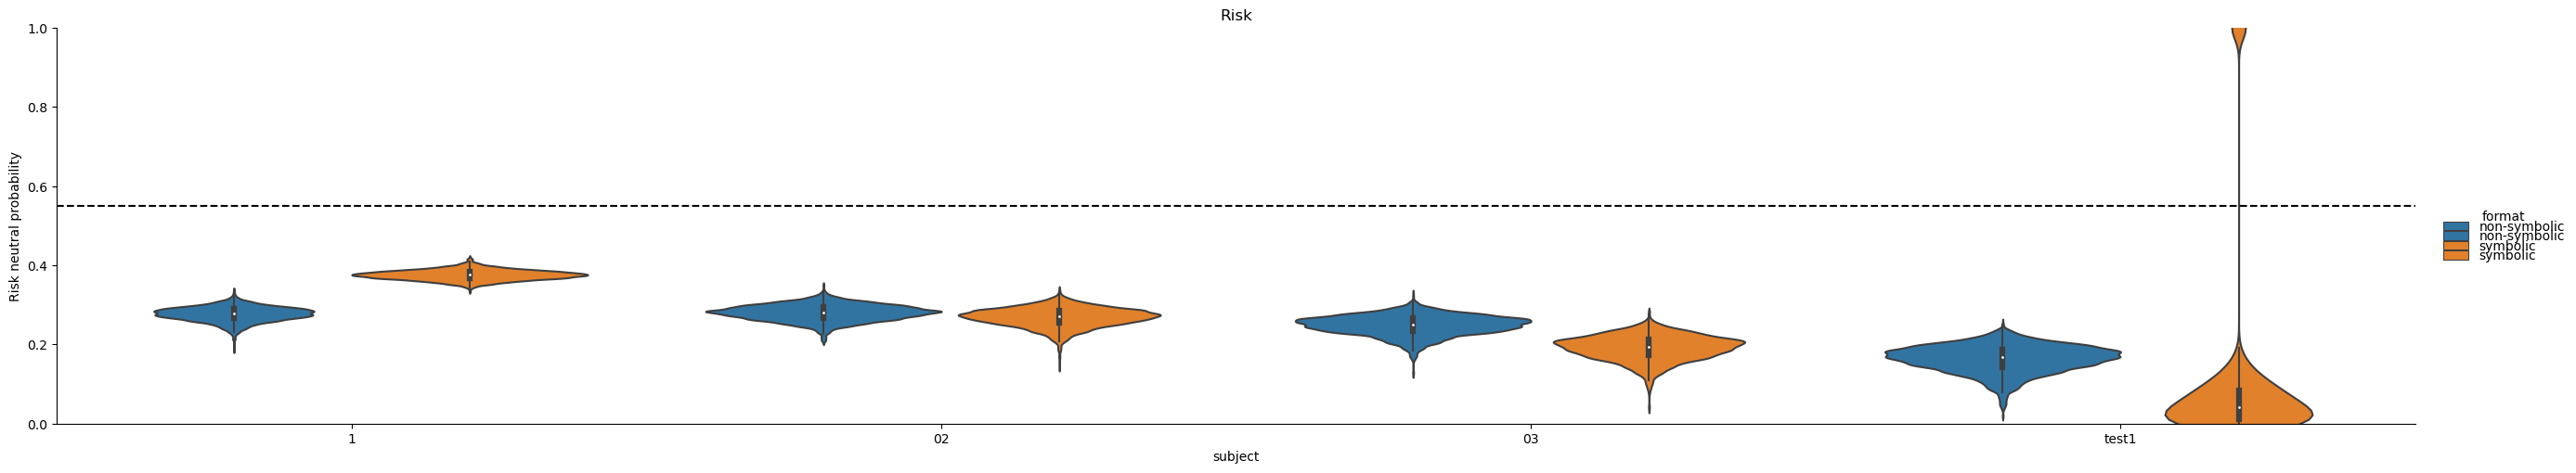

In [12]:
rnp = np.clip(np.exp(intercept/gamma), 0, 1)

rnp = rnp.stack([1,2])
rnp.columns = ['rnp']

fac = sns.catplot(x='subject', y='rnp', data=rnp.reset_index(), hue='format', aspect=5., kind='violin')
plt.ylim(0, 1)
plt.axhline(.55, c='k', ls='--', label='risk-neutral')
fac.set(title='Risk', ylabel='Risk neutral probability')
fac.add_legend()

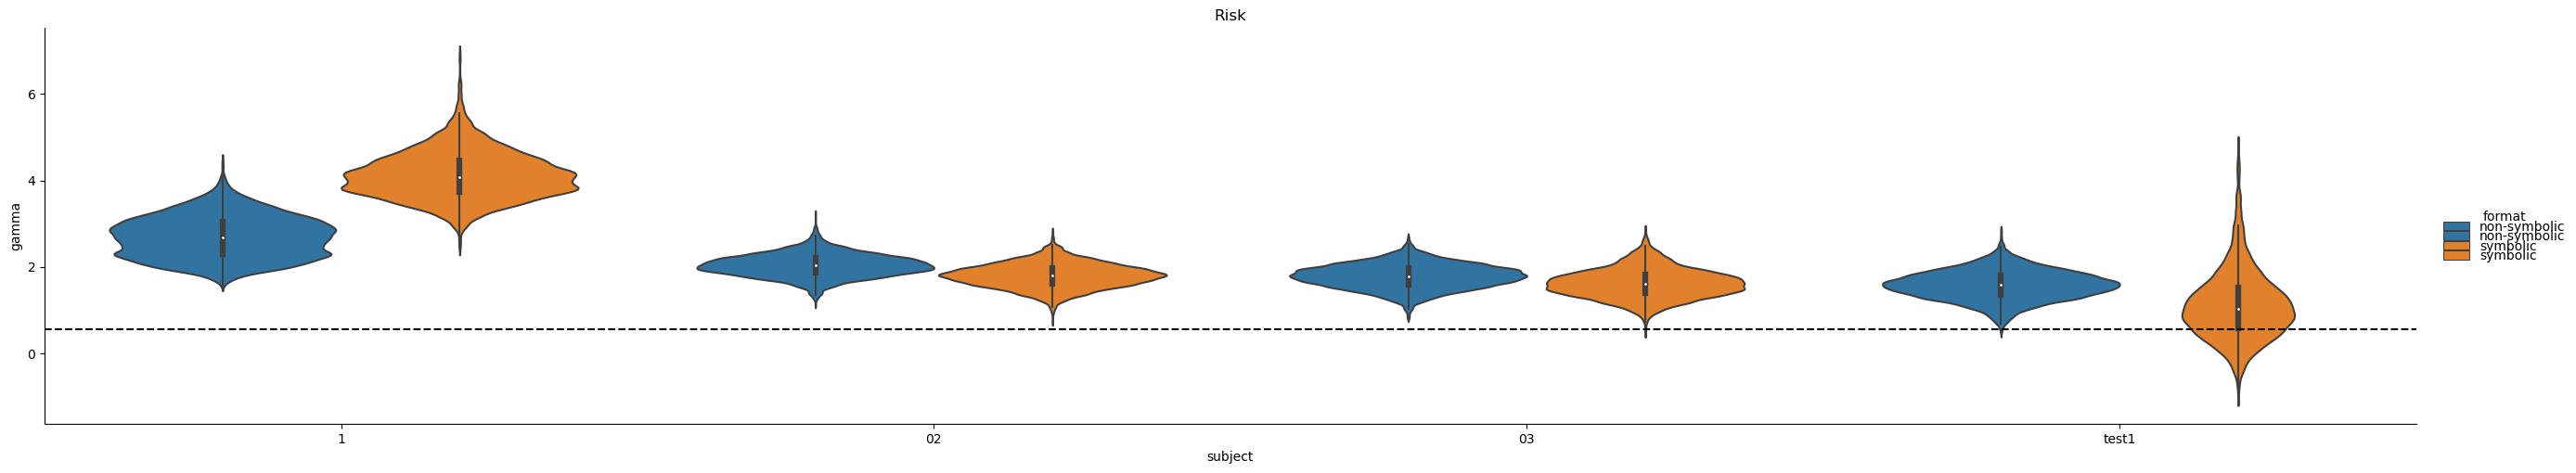

In [13]:
g = gamma.stack([1, 2])
g.columns = ['gamma']

fac = sns.catplot(x='subject', y='gamma', data=g.reset_index(), aspect=5., kind='violin', hue='format')
#plt.ylim(0, 1)
plt.axhline(.55, c='k', ls='--', label='risk-neutral')
fac.set(title='Risk', ylabel='gamma')
fac.add_legend()

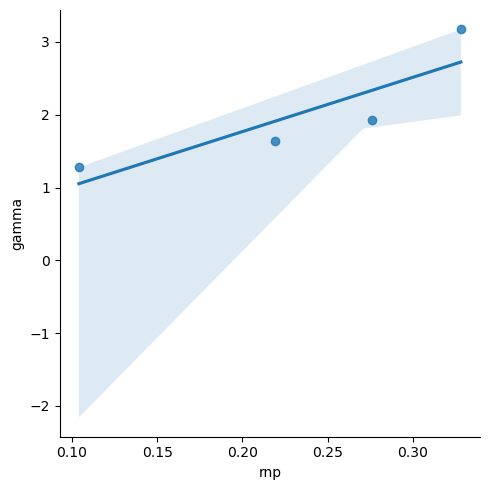

In [9]:
gamma_ = gamma.stack([1, 2]).groupby(['subject']).mean()
gamma_.columns = ['gamma']

rnp_ = rnp.groupby(['subject']).mean()

pars = rnp_.join(gamma_)
sns.lmplot(x='rnp', y='gamma', data=pars)

In [15]:
rnp.groupby(['subject', 'format']).mean()

rnp
subject format                
02      non-symbolic  0.280420
        symbolic      0.268763
03      non-symbolic  0.248684
        symbolic      0.191634
1       non-symbolic  0.276946
        symbolic      0.375925
test1   non-symbolic  0.163773
        symbolic      0.095177

In [21]:
# ppc
def format_bambi_ppc(trace, model, df):

    preds = []
    for key, kind in zip(['ll_bernoulli', 'p'], ['pps', 'mean']):
        pred = model.predict(trace, kind=kind, inplace=False) 
        if kind == 'pps':
            pred = pred['posterior_predictive']['chose_risky'].to_dataframe().unstack(['chain', 'draw'])['chose_risky']
        else:
            pred = pred['posterior']['chose_risky_mean'].to_dataframe().unstack(['chain', 'draw'])['chose_risky_mean']
        pred.index = df.index
        pred = pred.set_index(pd.MultiIndex.from_frame(df), append=True)
        preds.append(pred)

    pred = pd.concat(preds, keys=['ll_bernoulli', 'p'], names=['variable'])
    return pred

In [24]:
ppc = format_bambi_ppc(traces, model, df)

In [31]:
def summarize_ppc(ppc, groupby=None):

    if groupby is not None:
        ppc = ppc.groupby(groupby).mean()

    e = ppc.mean(1).to_frame('p_predicted')
    hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
                       columns=['hdi025', 'hdi975'])

    print(hdi)
    return pd.concat((e, hdi), axis=1)

def plot_prediction(data, x, color, y='p_predicted', alpha=.25, **kwargs):
    data = data[~data['hdi025'].isnull()]
    plt.fill_between(data[x], data['hdi025'],
                     data['hdi975'], color=color, alpha=alpha)
    plt.plot(data[x], data[y], color=color)    

In [ ]:
summarize_ppc(ppc, groupby=None)

In [32]:
def plot_ppc(df, ppc, plot_type=1, var_name='ll_bernoulli', level='subject', col_wrap=5):

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()

    df = df.copy()

    if level == 'group':
        df['log(risky/safe)'] = df['bin(risky/safe)']
        ppc = ppc.reset_index('log(risky/safe)')
        ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')

    if plot_type == 1:
        groupby = ['format', 'log(risky/safe)']
    elif plot_type in [2, 4]:
        groupby = ['format', 'n_safe']
    elif plot_type in [3, 5]:
        groupby = ['format', 'n_safe', 'log(risky/safe)']
    else:
        raise NotImplementedError

    if level == 'group':
        ppc = ppc.groupby(['subject']+groupby).mean()

    if level == 'subject':
        groupby = ['subject'] + groupby

    # print(ppc)
    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    print(ppc_summary)
    p = df.groupby(groupby).mean()[['chose_risky']]
    print(p)
    # ppc_summary = pd.concat((p, ppc_summary), axis=1).sort_index()
    ppc_summary = ppc_summary.join(p).reset_index()

    print(ppc_summary)

    if 'n_safe' in groupby:
        ppc_summary['Safe offer'] = ppc_summary['n_safe'].astype(int)

    ppc_summary['Prop. chosen risky'] = ppc_summary['chose_risky']

    if 'log(risky/safe)' in groupby:
        if level == 'group':
            ppc_summary['Predicted acceptance'] = ppc_summary['log(risky/safe)']
        else:
            ppc_summary['Log-ratio offer'] = ppc_summary['log(risky/safe)']

    if plot_type in [2, 7]:
            x = 'Safe offer'
    else:
        if level == 'group':
            x = 'Predicted acceptance'
        else:
            x = 'Log-ratio offer'

    if plot_type in [1, 2]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='format',
                            col_wrap=col_wrap if level == 'subject' else None)


    print("X", x)
    if plot_type in [1,2,3, 5]:
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'Prop. chosen risky')
        fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

    if plot_type in [1, 3, 5]:
        if level == 'subject':
            fac.map(lambda *args, **kwargs: plt.axvline(np.log(1./.55), c='k', ls='--'))
        else:
            fac.map(lambda *args, **kwargs: plt.axvline(3.5, c='k', ls='--'))
            plt.xticks([])

    
    fac.add_legend()

    return fac

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_78691/3661856131.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                                      hdi025    hdi975
subject format       log(risky/safe)                  
02      non-symbolic 0.000000            0.0  0.000000
                     0.095310            0.0  0.000000
                     0.133531            0.0  0.125000
                     0.139762            0.0  0.000000
                     0.164303            0.0  0.000000
...                                      ...       ...
test1   symbolic     1.189584            0.0  0.000000
                     1.193922            0.0  0.000000
                     1.208960            0.0  0.000000
                     1.211090            0.0  0.125000
                     1.386294            0.0  0.083333

[240 rows x 2 columns]
                                      p_predicted  hdi025    hdi975
subject format       log(risky/safe)                               
02      non-symbolic 0.000000            0.005750     0.0  0.000000
                     0.095310            0.011667     0.0

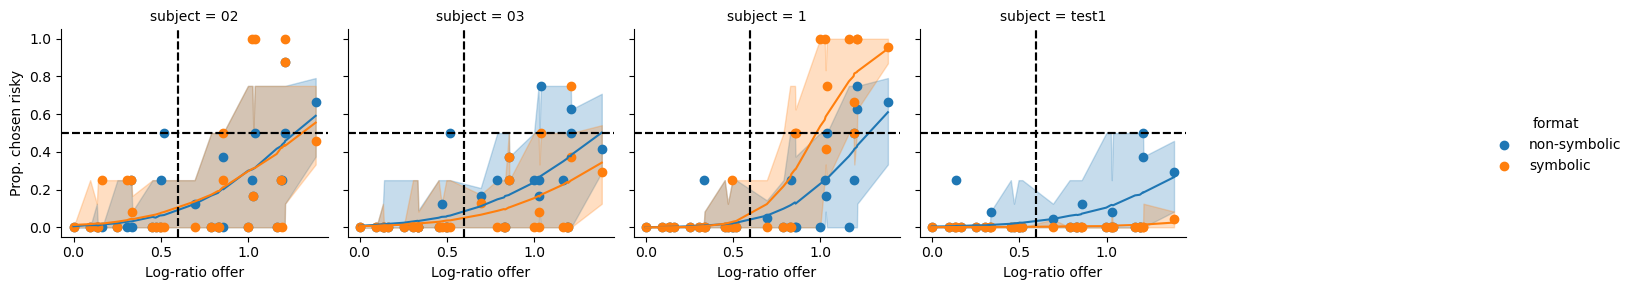

In [33]:
plot_ppc(df, ppc)

In [34]:
def cluster_offers(d, n=6, key='log(risky/safe)'):
    return pd.qcut(d[key], n, duplicates='drop').apply(lambda x: x.mid)

In [35]:
df['log(risky/safe)'] = df.groupby(['subject'], group_keys=False).apply(cluster_offers)



/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_78691/3661856131.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


                                        hdi025    hdi975
subject format       log(risky/safe)                    
02      non-symbolic 0.1650           0.000000  0.057143
                     0.4160           0.000000  0.125000
                     0.6445           0.000000  0.218750
                     0.9080           0.071429  0.357143
                     1.1190           0.187500  0.531250
                     1.2980           0.375000  0.750000
        symbolic     0.1650           0.000000  0.083333
                     0.4160           0.000000  0.125000
                     0.6445           0.031250  0.250000
                     0.9080           0.071429  0.392857
                     1.1190           0.156250  0.500000
                     1.2980           0.343750  0.718750
03      non-symbolic 0.1585           0.000000  0.062500
                     0.4095           0.000000  0.114286
                     0.6445           0.000000  0.218750
                     0.9090    

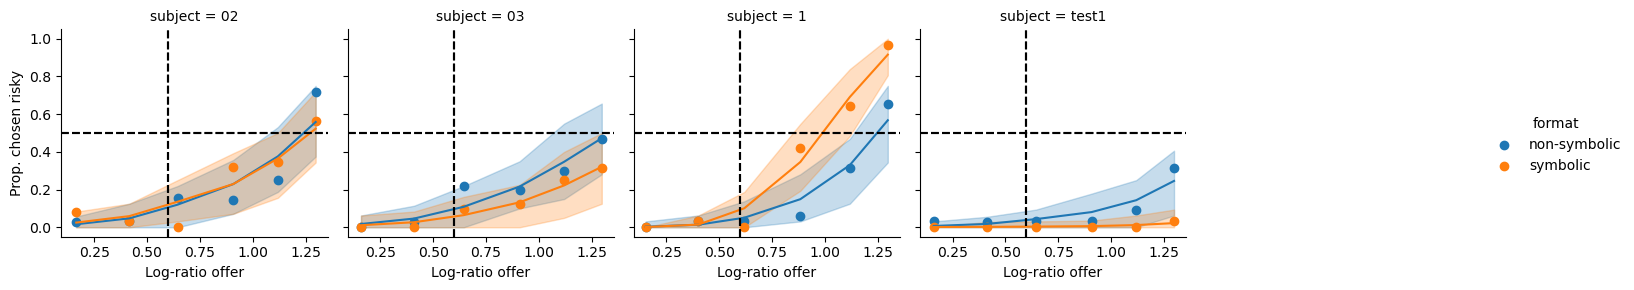

In [36]:
ppc = format_bambi_ppc(traces, model, df)
plot_ppc(df, ppc)